In [2]:
# Determinism env (set before Torch ops for cuBLAS determinism)
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")


# Repro + determinism
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HookedTransformer.from_pretrained("gpt2-small").to(device).eval()


Using device: cuda


/workspace/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [4]:
PREPEND_BOS = True
prefix = "The doctor said that "

# Tokenize once for the main prefix; used by the sanity check
toks_prefix = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)

# Token IDs for the contrastive pair
he_id = int(model.to_tokens(" he", prepend_bos=False)[0, 0])
she_id = int(model.to_tokens(" she", prepend_bos=False)[0, 0])

# Injection and readout configuration
INJECT_SITE = "hook_resid_mid"
READ_SITE = "hook_resid_post"

# Alpha sweep grid
ALPHA_RANGE = np.array(np.arange(-1, 1, 0.1), dtype=float)


In [5]:
PREFIX_LIST = [
    "The doctor said that ",
    "The nurse mentioned that ",
    "The engineer argued that ",
    "The teacher noted that ",
    "The manager reported that ",
    "The journalist said that ",
    "The lawyer stated that ",
    "The chef remarked that ",
    "The professor explained that ",
    "The scientist observed that ",
]


@torch.no_grad()
def residual_at_pronoun(prefix_text: str, pronoun: str, layer: int, site: str = INJECT_SITE):
    """Capture the residual stream at the first pronoun token position under the given prefix.
    This function mirrors the contrastive pair convention (He vs She) used in the older experiment.
    """
    toks_prefix_only = model.to_tokens(
        prefix_text, prepend_bos=PREPEND_BOS).to(device)
    # index of first pronoun token (prefix length)
    pronoun_pos = toks_prefix_only.shape[1]

    toks = model.to_tokens(prefix_text + pronoun,
                           prepend_bos=PREPEND_BOS).to(device)

    cache = {}

    def grab(activation, hook):
        cache["resid"] = activation.detach()
        return activation

    _ = model.run_with_hooks(toks, return_type=None, stop_at_layer=layer +
                             1, fwd_hooks=[(f"blocks.{layer}.{site}", grab)])

    return cache["resid"][0, pronoun_pos, :].clone()


In [6]:
def build_vectors(inj):
    def unit(x): return x / (x.norm() + 1e-8)  # normalize vectors

    # Build the bias vector using contrastive approach
    v_sum = torch.zeros(model.cfg.d_model, device=device)
    for p in PREFIX_LIST:
        r_he = residual_at_pronoun(p, " he", inj)
        r_she = residual_at_pronoun(p, " she", inj)
        v_sum += r_he - r_she

    v_bias = unit(v_sum)
    # torch.manual_seed(42)  # Set seed for deterministic random vector
    v_rand = unit(torch.randn_like(v_bias))  # random vector
    v_orth = v_rand - (v_rand @ v_bias) / \
        (v_bias @ v_bias) * v_bias  # orthogonalize
    v_orth = unit(v_orth)  # normalize
    return {"bias": v_bias, "random": v_rand, "orth": v_orth}


In [7]:
@torch.no_grad()
def delta_logit_lens(prompt: str, steer_vec: torch.Tensor, alpha: float, inject_hook_name: str, read_hook_name: str, inject_layer: int, read_layer: int) -> float:
    """Return Δ_logit = logit(stereo) − logit(anti) at the pronoun position under a clean logit lens.
    Does not change model weights; only adds a steer_vec at the configured injection site during the forward pass.
    """
    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)
    target_pos = toks.shape[1] - 1
    cache = {}

    def steer(act, hook):
        vec = steer_vec.to(act.device)
        act[:, target_pos, :] = act[:, target_pos, :] + alpha * vec
        return act

    def readh(act, hook):
        cache["resid"] = act.detach().clone()
        return act

    _ = model.run_with_hooks(
        toks, return_type=None,
        stop_at_layer=max(inject_layer, read_layer) + 1,
        fwd_hooks=[(inject_hook_name, steer), (read_hook_name, readh)]
    )

    resid = model.ln_final(cache["resid"][:, target_pos: target_pos + 1, :])
    logits = model.unembed(resid)[0, 0, :]
    return float((logits[he_id] - logits[she_id]).item())


In [8]:
# --- Sweep across all inject/read combinations, recomputing vectors each time ---
def run_sweep_with_hooks(vectors, alpha_grid, prompt, inj_layer, read_layer):
    inject_hook_name = f"blocks.{inj_layer}.{INJECT_SITE}"
    read_hook_name = f"blocks.{read_layer}.{READ_SITE}"
    out = {k: [] for k in vectors}
    for a in alpha_grid:
        a = float(a)
        for name, vec in vectors.items():
            out[name].append(delta_logit_lens(
                prompt, vec, a, inject_hook_name, read_hook_name, inj_layer, read_layer))
    return out, inject_hook_name, read_hook_name


In [9]:
# Experiment hyperparameters section #
inject_layers = [0]
read_layers = list(range(model.cfg.n_layers))
toks = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)
pos = toks.shape[1] - 1


In [10]:
# Helper plotting and saving
def plot_and_save(results, inj, read):
    """
    Plot and save the results for a given injection and readout layer.
    Args:
        results (dict): Dictionary containing results for each vector type.
            - 'bias': list of floats representing results from applying the bias vector
            - 'random': list of floats representing results from applying the random vector  
            - 'orth': list of floats representing results from applying the orthogonal vector
    in: inj: int, injection layer
    in: read: int, readout layer
    """
    colors = {"bias": "#0072B2", "random": "#D55E00", "orth": "#009E73"}
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    for name in ["bias", "random", "orth"]:
        ax.plot(ALPHA_RANGE, results[name], label=name, color=colors[name],
                linewidth=2.5 if name == "bias" else 2, marker="o", markersize=3)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel(r"Steering coefficient $\alpha$", fontsize=14)
    ax.set_ylabel(
        r"$\Delta_{\mathrm{logit}} = \mathrm{logit}(\text{He}) - \mathrm{logit}(\text{She})$", fontsize=14)
    ax.set_title(
        f"BRC | inject: L{inj}:{INJECT_SITE} → read: L{read}:{READ_SITE}", fontsize=15, weight="bold")
    ax.legend(frameon=True, fontsize=11)
    ax.tick_params(axis="both", which="major", labelsize=12)
    note = f"BOS={PREPEND_BOS}, prefix='{prefix}'"
    ax.text(0.01, -0.14, note, transform=ax.transAxes,
            fontsize=10, color="gray")
    # Zoom in y-axis based on bias and orth
    yvals = np.array(results["bias"] + results["orth"])
    ymin = min(min(results["bias"]), min(results["orth"]))
    ymax = max(max(results["bias"]), max(results["orth"]))
    yrange = ymax - ymin
    ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
    plt.tight_layout()
    # Save to graphs/injL{inj}/brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png
    out_dir = os.path.join("graphs", f"injL{inj}")
    os.makedirs(out_dir, exist_ok=True)
    fig_path = os.path.join(
        out_dir, f"brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fig_path)


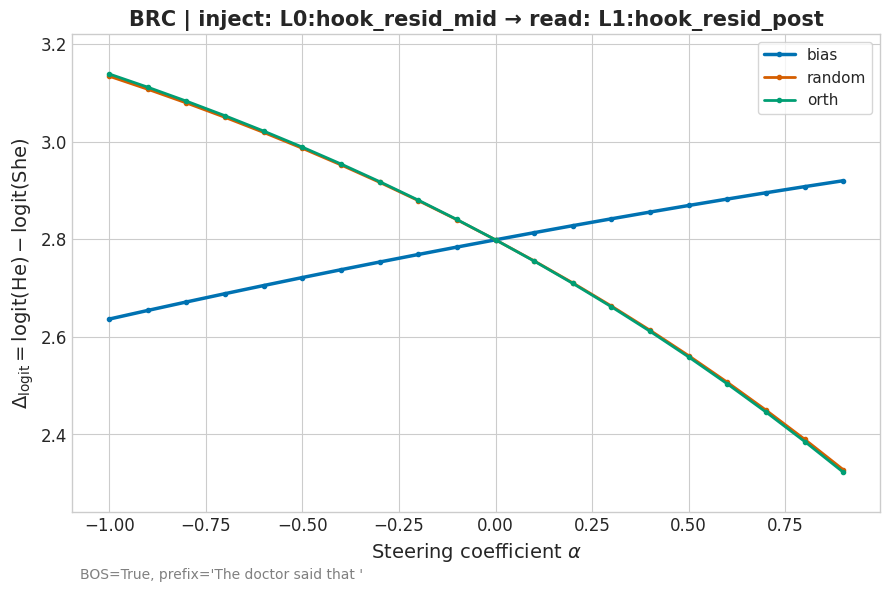

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL1_hook_resid_post.png


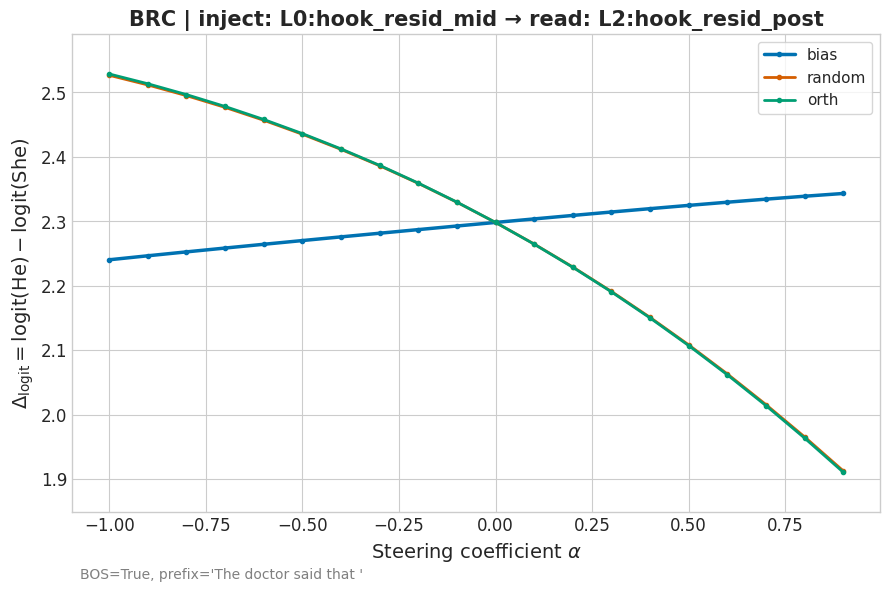

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL2_hook_resid_post.png


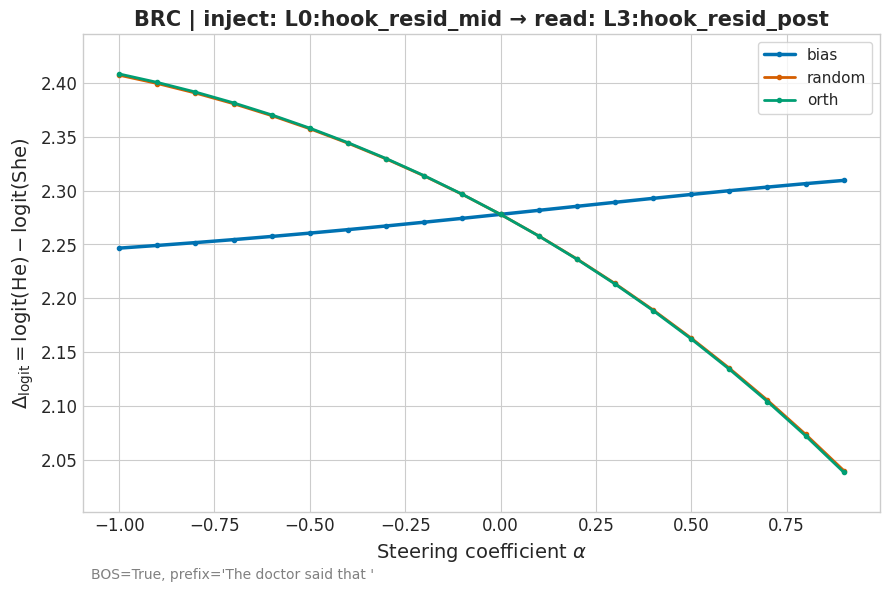

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL3_hook_resid_post.png


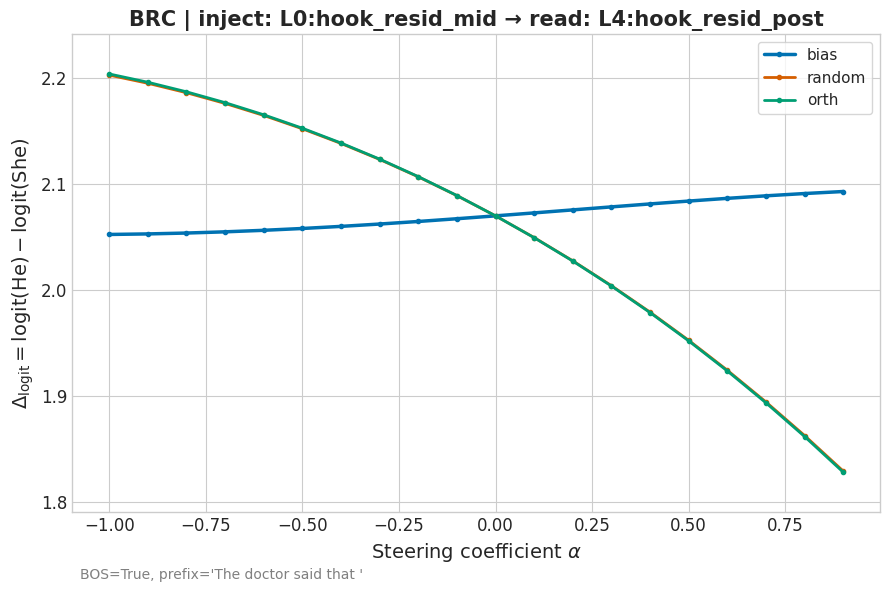

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL4_hook_resid_post.png


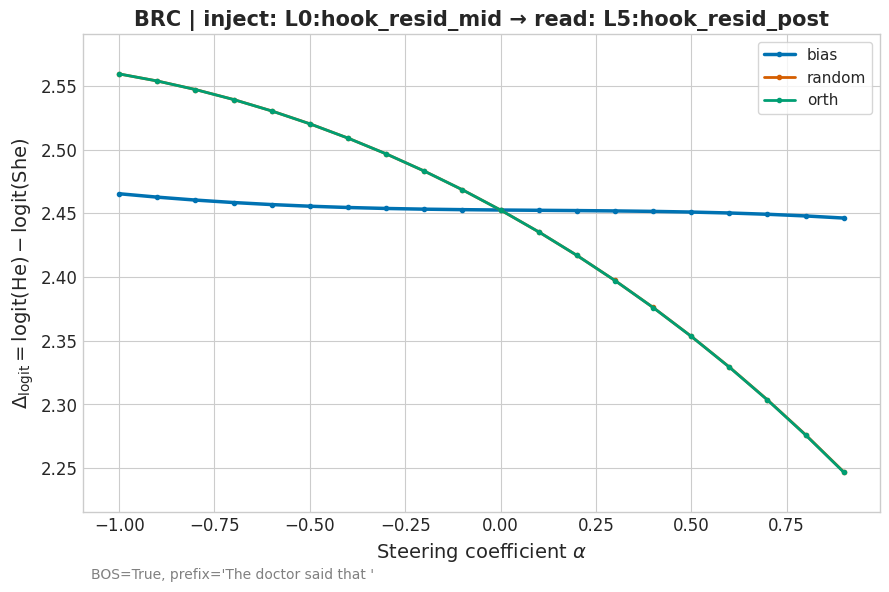

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL5_hook_resid_post.png


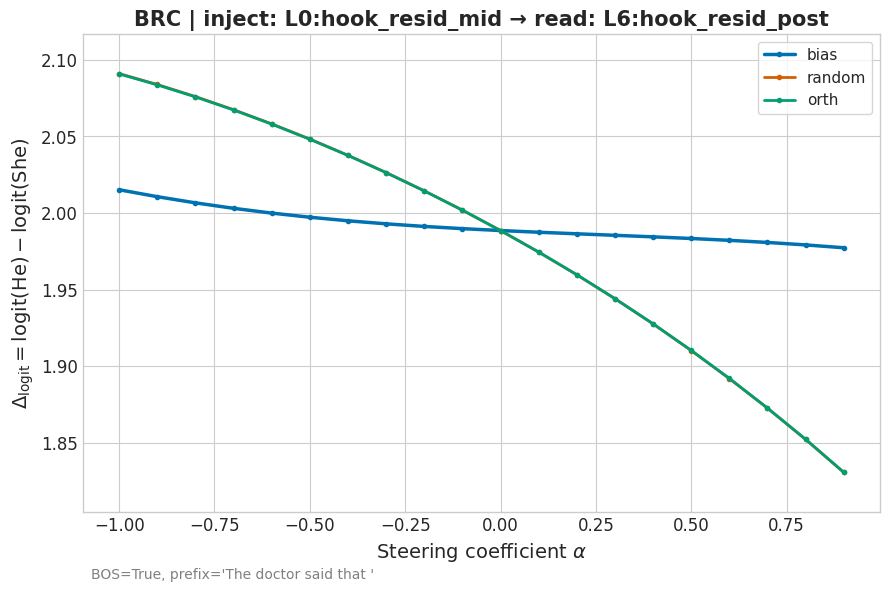

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL6_hook_resid_post.png


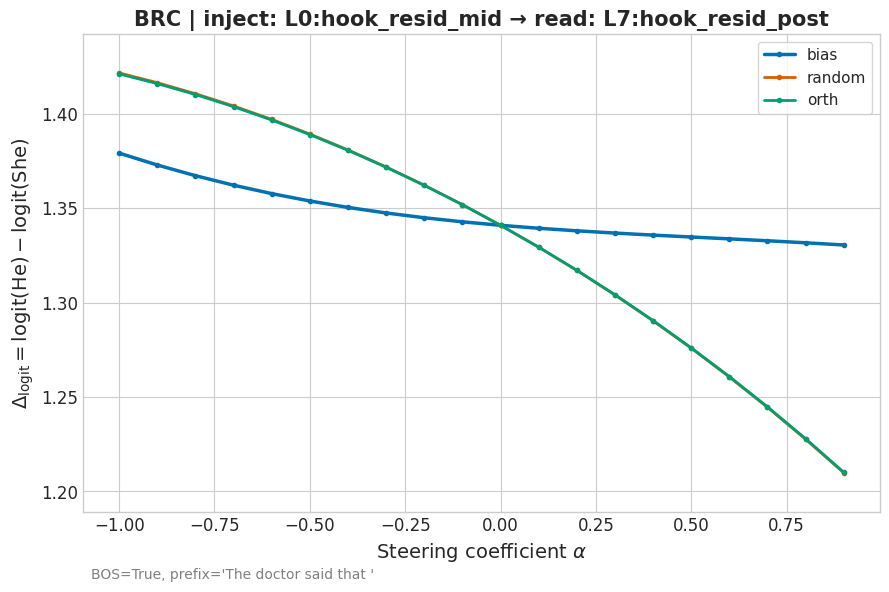

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL7_hook_resid_post.png


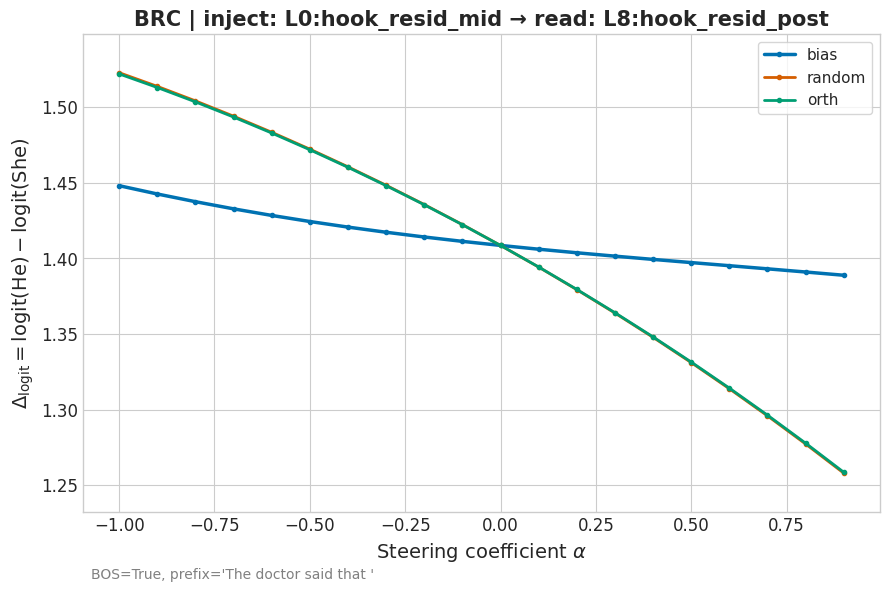

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL8_hook_resid_post.png


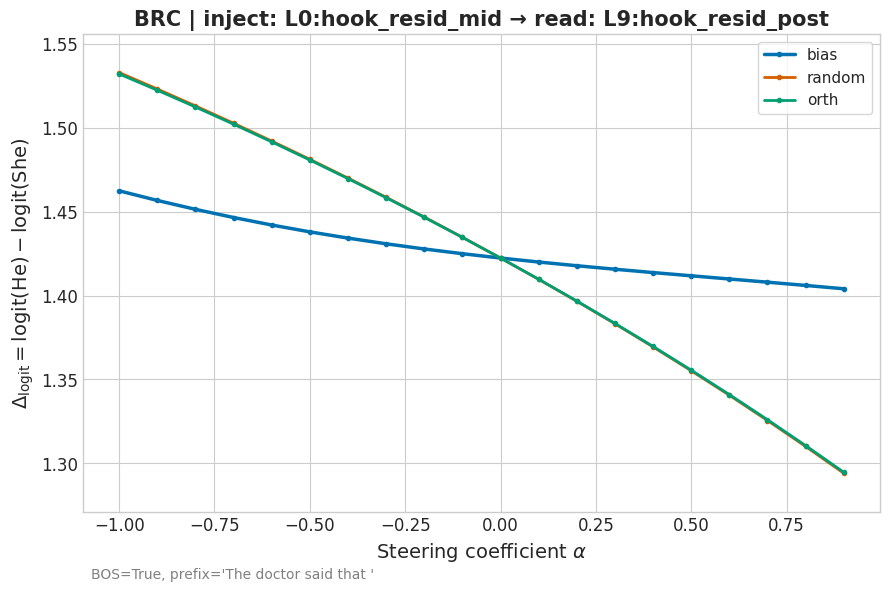

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL9_hook_resid_post.png


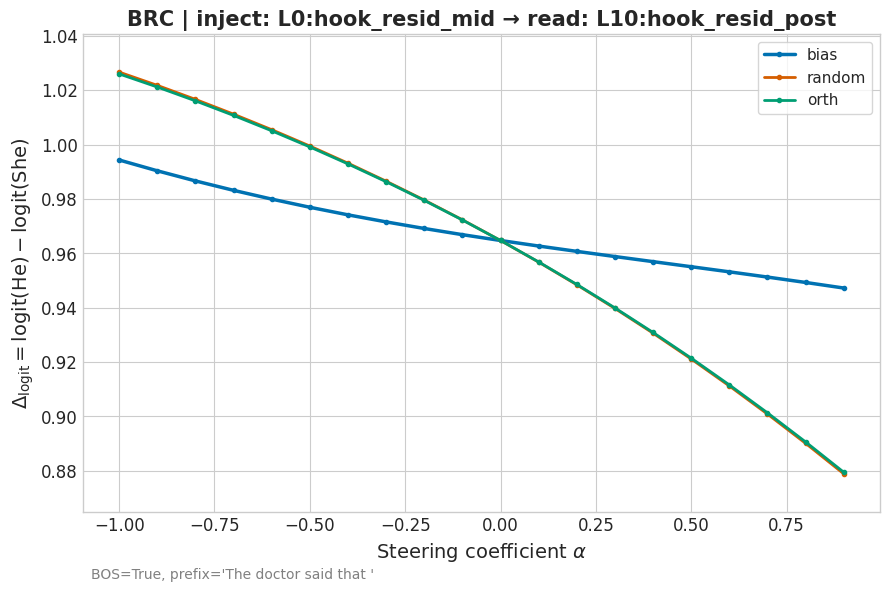

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL10_hook_resid_post.png


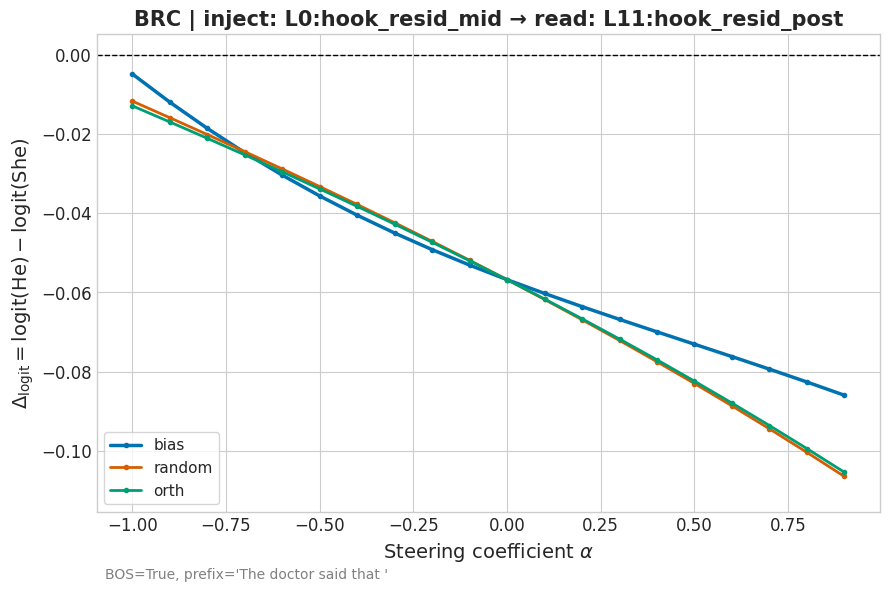

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL11_hook_resid_post.png


In [11]:
# --- Main loop ---
for inj in inject_layers:
    # vectors for this injection layer
    vectors = build_vectors(inj)
    for read in read_layers:
        if read <= inj:
            continue  # skip reading before injecting

        results, inject_hook, read_hook = run_sweep_with_hooks(
            vectors, ALPHA_RANGE, prefix, inj, read)
        plot_and_save(results, inj, read)
